In [1]:
#importing libraries
import numpy as np
import pandas as pd
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils import to_categorical, plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mping
import math 
import datetime
import time

In [2]:
#Default dimensions 
img_width, img_height = 224, 224

#Create a bottleneck file
top_model_weight_path = 'bottleneck_fc_model.h5'

In [3]:
#loading datasets
train = "E:\AutoFis\StockFish-1\\train"
test = "E:\AutoFis\StockFish-1\\test"
valid = "E:\AutoFis\StockFish-1\\valid"

In [4]:
#number of epochs to train top model
epochs = 20
#7

#batch size used by flow_from_directory and predict_generator
batch_size = 25
#50 

In [5]:
#loading vgg16 model
vgg16 = applications.VGG16(include_top = False, weights = 'imagenet')

In [6]:
#needed to create the bottleneck.npy files
datagen = ImageDataGenerator(rescale = 1. / 255)

In [7]:
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    train,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 719 images belonging to 5 classes.
29/29 [==============================] - 149s 5s/step
Time:  0:02:31.174496


In [8]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
    valid,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_valid_samples = len(generator.filenames)

predict_size_valid = int(math.ceil(nb_valid_samples / batch_size))

bottleneck_features_valid = vgg16.predict(
    generator, predict_size_valid
)

np.save('bottleneck_features_valid.npy', bottleneck_features_valid)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 207 images belonging to 5 classes.
9/9 [==============================] - 36s 4s/step
Time:  0:00:37.003165


In [9]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
    test,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_test_samples = len(generator.filenames)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))
bottleneck_features_test = vgg16.predict(generator, predict_size_test)
np.save('bottleneck_features_test.npy', bottleneck_features_test)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 103 images belonging to 5 classes.
5/5 [==============================] - 19s 3s/step
Time:  0:00:19.762511


In [10]:
#training data
generator_top = datagen.flow_from_directory(
    train,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

#load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')

#get the class label for the training data in the original order
train_labels = generator_top.classes

#convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes = num_classes)

Found 719 images belonging to 5 classes.


In [11]:
#validation data
generator_top = datagen.flow_from_directory(
    valid,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_valid_samples = len(generator_top.filenames)

valid_data = np.load('bottleneck_features_valid.npy')

valid_labels = generator_top.classes
valid_labels = to_categorical(valid_labels, num_classes = num_classes)

Found 207 images belonging to 5 classes.


In [12]:
#testing data
generator_top = datagen.flow_from_directory(
    test,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_test_samples = len(generator_top.filenames)

test_data = np.load('bottleneck_features_test.npy')

test_labels = generator_top.classes
test_labels = to_categorical(test_labels, num_classes = num_classes)

Found 103 images belonging to 5 classes.


In [13]:
#training the model
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape = train_data.shape[1:]))
model.add(Dense(100, activation = keras.layers.LeakyReLU(alpha = 0.3)))
model.add(Dropout(0.5))
model.add(Dense(50, activation = keras.layers.LeakyReLU(alpha = 0.3)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate = 1e-4),
              metrics = ['acc'])

history = model.fit(train_data, train_labels,
                    epochs = 20,  #7
                    batch_size = batch_size,
                    validation_data = (valid_data, valid_labels))

model.save_weights(top_model_weight_path)

(eval_loss, eval_accuracy) = model.evaluate(
    valid_data, valid_labels, batch_size = batch_size, verbose = 1
)

print("[INFO] Accuracy: ", format(eval_accuracy * 100))
print("[INFO] Loss: ", format(eval_loss))
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Epoch 1/20
29/29 [==============================] - 2s 47ms/step - loss: 1.5495 - acc: 0.3700 - val_loss: 1.1322 - val_acc: 0.4686
Epoch 2/20
29/29 [==============================] - 1s 38ms/step - loss: 1.0692 - acc: 0.5702 - val_loss: 0.8032 - val_acc: 0.7778
Epoch 3/20
29/29 [==============================] - 1s 43ms/step - loss: 0.8298 - acc: 0.6648 - val_loss: 0.6322 - val_acc: 0.7971
Epoch 4/20
29/29 [==============================] - 1s 45ms/step - loss: 0.6864 - acc: 0.7399 - val_loss: 0.5063 - val_acc: 0.8889
Epoch 5/20
29/29 [==============================] - 1s 45ms/step - loss: 0.5275 - acc: 0.8192 - val_loss: 0.4597 - val_acc: 0.8454
Epoch 6/20
29/29 [==============================] - 1s 49ms/step - loss: 0.4462 - acc: 0.8275 - val_loss: 0.3222 - val_acc: 0.9130
Epoch 7/20
29/29 [==============================] - 2s 54ms/step - loss: 0.4124 - acc: 0.8554 - val_loss: 0.2908 - val_acc: 0.9324
Epoch 8/20
29/29 [==============================] - 2s 53ms/step - loss: 0.3414 - a

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 2514205 (9.59 MB)
Trainable params: 251420

In [15]:
plot_model(model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


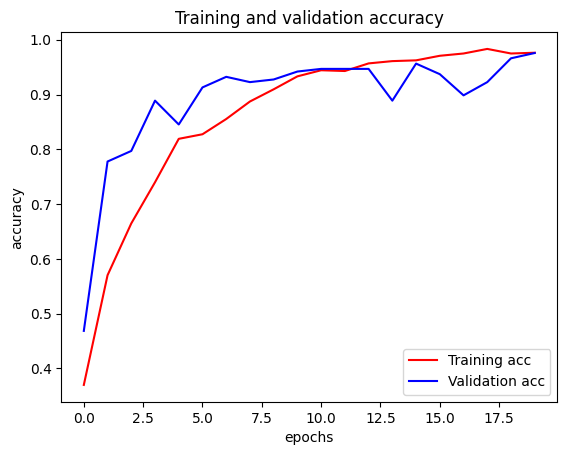

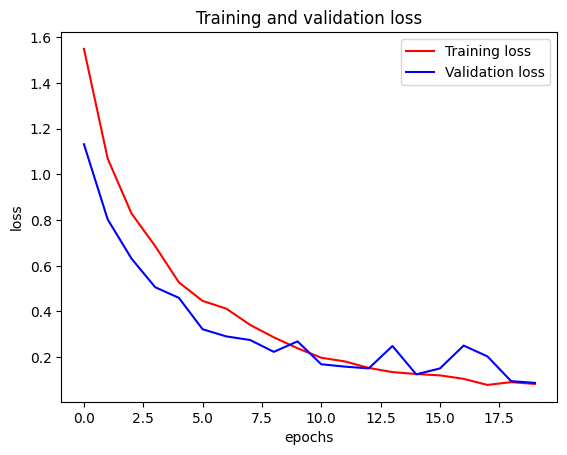

In [16]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [17]:
#model evaluation on testing data
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 5ms/step - loss: 0.1068 - acc: 0.9806


[0.10680694878101349, 0.9805825352668762]

In [18]:
#Classification metrics
print('test data', test_data)
preds = np.round(model.predict(test_data), 0)

#to fit them into classification metrics and confusion metrics, some additional modifications are required
print('Rounded test_labels', preds)

test data [[[[1.38385683e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    8.23269010e-01 0.00000000e+00]
   [0.00000000e+00 3.29277694e-01 0.00000000e+00 ... 0.00000000e+00
    6.12689912e-01 0.00000000e+00]
   [8.86367559e-01 2.58799672e-01 0.00000000e+00 ... 0.00000000e+00
    7.41989017e-01 0.00000000e+00]
   ...
   [6.29470587e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.63139558e+00 0.00000000e+00]
   [4.22878414e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    2.46933889e+00 0.00000000e+00]
   [2.76924312e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.93712687e+00 0.00000000e+00]]

  [[1.15594125e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.93276548e-01 0.00000000e+00]
   [5.74381948e-01 6.07460141e-02 0.00000000e+00 ... 0.00000000e+00
    3.14417422e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.99348074e-01 0.00000000e+00]
   ...
   [3.02218944e-01 0.00000000e+00 0.00000000e+0

In [19]:
fish = ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp']
classification_metrics = metrics.classification_report(test_labels, preds, target_names = fish, zero_division = 1)
print(classification_metrics)

              precision    recall  f1-score   support

       Catla       0.96      1.00      0.98        22
  CommonCarp       1.00      0.89      0.94        19
        Mori       1.00      1.00      1.00        16
        Rohu       0.95      1.00      0.97        19
  SilverCarp       1.00      1.00      1.00        27

   micro avg       0.98      0.98      0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103
 samples avg       0.98      0.98      1.00       103



In [20]:
#Confusion Matrix
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis = 1)
categorical_preds = pd.DataFrame(preds).idxmax(axis = 1)

In [21]:
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion matrix with normalization option'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", color = "white" if cm[i, j] > thresh else 'blue')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


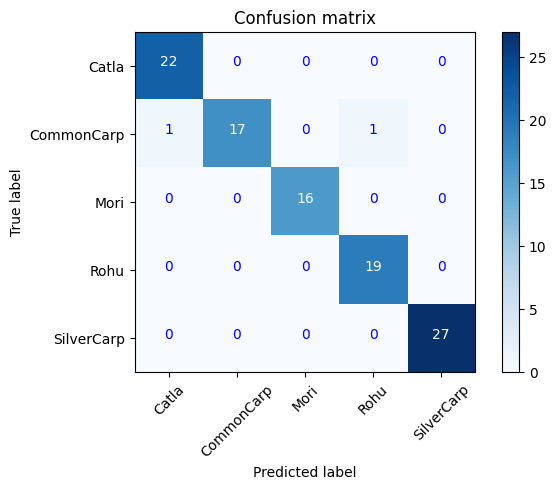

In [23]:
plot_confusion_matrix(confusion_matrix, ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp'])

Normalized confusion matrix


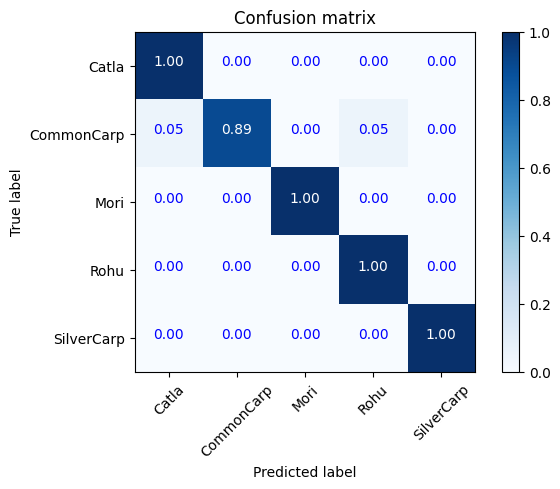

In [24]:
#Normalized confusion matrix
plot_confusion_matrix(confusion_matrix, ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp'],
                      normalize = True)

In [25]:
#testing images on model
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")
    image = load_img(file_path, target_size = (224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image /= 255.
    return image

In [26]:
def test_single_image(path):
    fish = ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    preds = model.predict(bt_prediction)
    for idx, fish, x in zip(range(0, 5), fish, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, fish, x*100 ))
    print("Final Decision: ")
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    #class_predicted = model.predict_classes(bt_prediction)
    class_predicted = model.predict(bt_prediction)
    classes = np.argmax(class_predicted, axis = 1)
    class_dictionary = generator_top.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()}
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[classes[0]]))
    return load_img(path)

In [27]:
path = r"E:\AutoFis\silcafish.jpg"

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 23ms/step
ID: 0, Label: Catla 23.281055688858032%
ID: 1, Label: CommonCarp 0.02401901874691248%
ID: 2, Label: Mori 0.00042893934733001515%
ID: 3, Label: Rohu 0.009528809459879994%
ID: 4, Label: SilverCarp 76.68496370315552%
Final Decision: 
.
..
...
1/1 [==============================] - 0s 31ms/step
ID: [2.3281056e-01 2.4019019e-04 4.2893935e-06 9.5288095e-05 7.6684964e-01], Label: SilverCarp


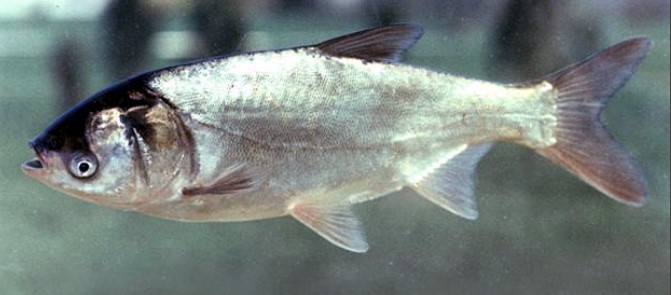

In [28]:
test_single_image(path)